In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/TeA/project/datalog/datasets"
!pwd
!ls -la

/content/drive/My Drive/TeA/project/datalog/datasets
/content/drive/My Drive/TeA/project/datalog/datasets
total 96896
-rw------- 1 root root 99221152 Aug 21 08:16 logwireshark.csv.npy


In [3]:
#Install Keract Python on Google Colab
!pip install keract
import numpy as np
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
import keras
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from keract import get_activations, display_activations
import sklearn.metrics
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix 
import datetime
import numpy

def escape():
    sys.exit()


In [5]:
#import_directory = "/content/drive/My Drive/TeA/project/dataset/extract/"
#import_directory = "/content/drive/My Drive/TeA/dataset/datasets/"
import_directory = "/content/drive/My Drive/TeA/project/datalog/datasets/"

temp_arr = np.zeros((0,3073), dtype=int)
data_array_backup = temp_arr.astype(int)
files = os.listdir(import_directory)

for file in files:
    print('Opening File :', file)
    data_set = np.load(import_directory+file, allow_pickle=True)
    data_array_backup = np.vstack((data_array_backup, data_set))

data_array = np.copy(data_array_backup)

Opening File : logwireshark.csv.npy


In [6]:
img_row = 32
img_col = 32
train_test_split_percentage = 0.8
np.random.shuffle(data_array)
N = np.shape(data_array)[0]

X_train = data_array[:int(N * train_test_split_percentage), :3072]
print(X_train.shape)
X_test = data_array[int(N * train_test_split_percentage):, :3072]
print(X_test.shape)

X_train = np.array([x.reshape(img_row, img_col, 3) for x in X_train])
print(X_train.shape)
X_test = np.array([x.reshape(img_row, img_col, 3) for x in X_test])
print(X_test.shape)

trainX = np.copy(X_train)
testX = np.copy(X_test)

(3228, 3072)
(808, 3072)
(3228, 32, 32, 3)
(808, 32, 32, 3)


In [7]:
y_train = data_array[:int(N * train_test_split_percentage), 3072]
print(y_train.shape)
y_test = data_array[int(N * train_test_split_percentage):, 3072]
print(y_test.shape)

trainY = np.array([[x] for x in y_train])
print(y_train.shape)
testY = np.array([[x] for x in y_test])
print(y_test.shape)

(3228,)
(808,)
(3228,)
(808,)


In [8]:
model_vgg19_conv = VGG19(include_top=False, weights='imagenet', input_shape=(img_col, img_row, 3))

80142336/80134624 [==============================] - 1s 0us/step


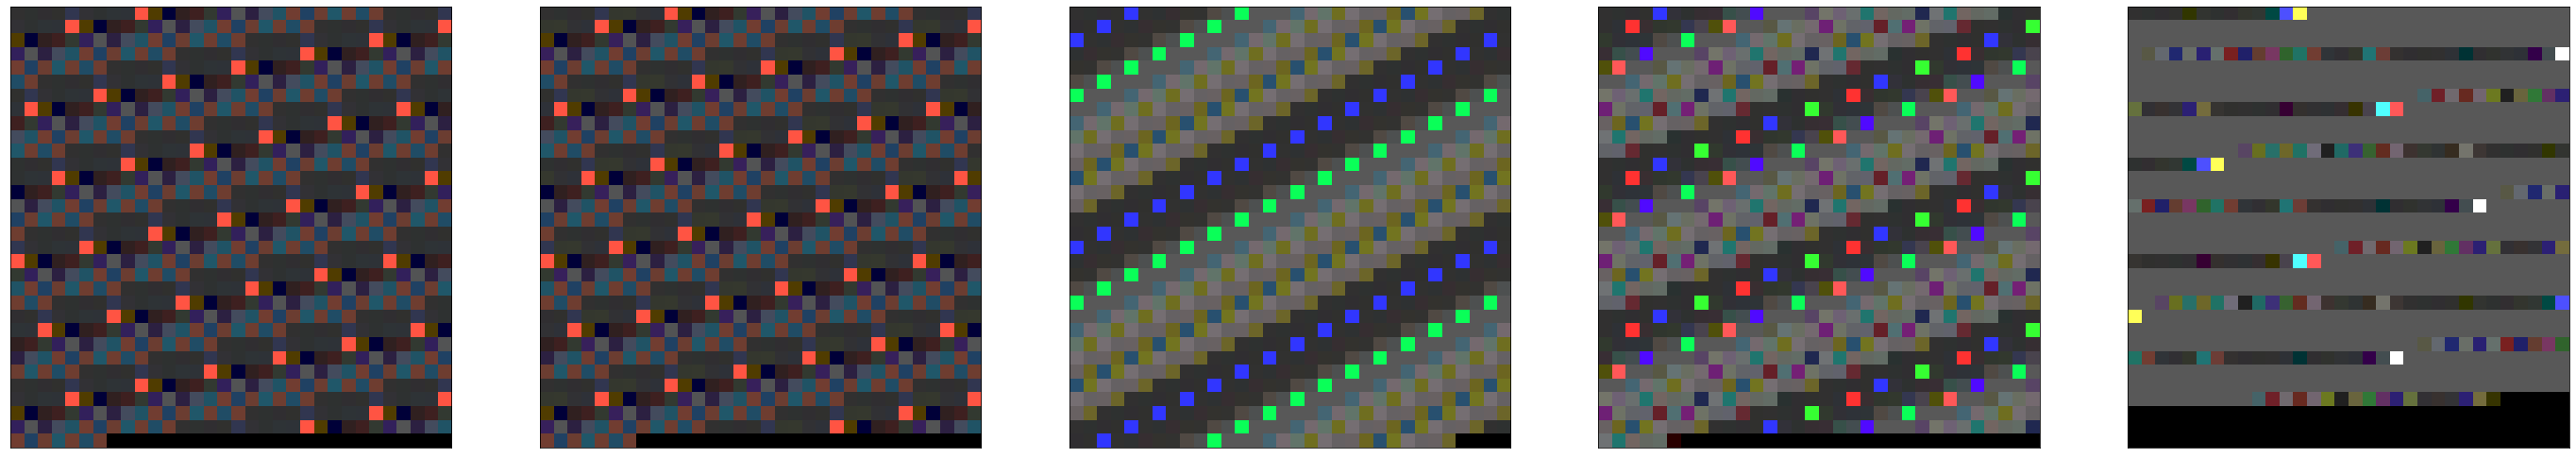

In [9]:
#ploting images for data
%matplotlib inline
n = 32  # how many digits we will display
fig = plt.figure(figsize=(320, 320))
for i in range(6,11):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(trainX[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()
plt.close()

In [10]:
for layer in model_vgg19_conv.layers:
    layer.trainable = False
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
x = model_vgg19_conv.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

my_model = Model(model_vgg19_conv.input, x)
my_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)        

In [12]:
my_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

epochs = 5

In [13]:
start = datetime.datetime.now()
hist = my_model.fit(trainX, trainY,
          epochs=epochs,
          verbose=1,
          validation_split=0.2)
score = my_model.evaluate(testX, testY, verbose=1)
print("="*10)
print('Time taken : {}'.format(datetime.datetime.now() - start))
print("="*10)

Epoch 1/5
81/81 [==============================] - 1s 15ms/step - loss: 0.1412 - accuracy: 0.9888 - val_loss: 2.7958e-06 - val_accuracy: 1.0000
Epoch 2/5
81/81 [==============================] - 1s 10ms/step - loss: 2.3730e-07 - accuracy: 1.0000 - val_loss: 5.9617e-06 - val_accuracy: 1.0000
Epoch 3/5
81/81 [==============================] - 1s 10ms/step - loss: 9.4931e-09 - accuracy: 1.0000 - val_loss: 4.3404e-06 - val_accuracy: 1.0000
Epoch 4/5
81/81 [==============================] - 1s 10ms/step - loss: 1.3947e-09 - accuracy: 1.0000 - val_loss: 2.4545e-06 - val_accuracy: 1.0000
Epoch 5/5
26/26 [==============================] - 0s 10ms/step - loss: 3.7533e-10 - accuracy: 1.0000
Time taken : 0:00:11.805354


In [14]:
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

Test Loss: 0.00%
Test Accuracy: 100.00%


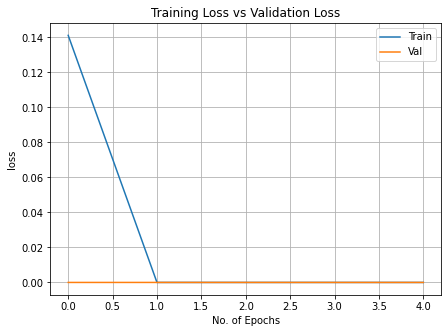

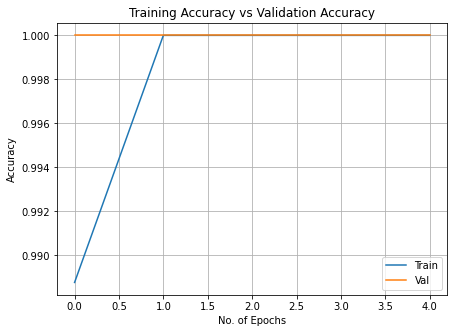

In [15]:
training_loss= hist.history['loss']
val_loss= hist.history['val_loss'] 
training_acc= hist.history['accuracy'] 
val_acc= hist.history['val_accuracy']
xc=range(epochs)

plt.figure(1,figsize=(7,5)) 
plt.plot(xc,training_loss)
plt.plot(xc,val_loss) 
plt.xlabel('No. of Epochs') 
plt.ylabel('loss') 
plt.title('Training Loss vs Validation Loss') 
plt.grid(True) 
plt.legend(['Train','Val'])
plt.savefig(import_directory+'Loss.png', dpi=300)

plt.figure(2,figsize=(7,5)) 
plt.plot(xc,training_acc) 
plt.plot(xc,val_acc) 
plt.xlabel('No. of Epochs') 
plt.ylabel('Accuracy') 
plt.title('Training Accuracy vs Validation Accuracy') 
plt.grid(True) 
plt.legend(['Train','Val'],loc=4)
plt.savefig(import_directory+'Accuracy.png', dpi=300)

total length =  808
DoS Attack =  271
Normal =  537


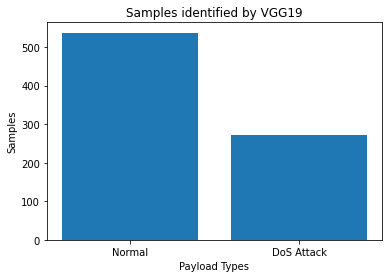

In [16]:
checking_occurences = [x for x in testY if x == 1]
print("total length = ",len(testY))
print("DoS Attack = ",len(checking_occurences))
print("Normal = ", (len(testY) - len(checking_occurences)))

n = len(testY) - len(checking_occurences)
a = len(checking_occurences)

label = ['Normal', 'DoS Attack']
samples = [n, a]

# this is for plotting purpose
index = np.arange(len(label))
plt.bar(index, samples)
plt.xlabel('Payload Types', fontsize=10)
plt.ylabel('Samples', fontsize=10)
plt.xticks(index, label, fontsize=10, rotation=0)
plt.title('Samples identified by VGG19')
plt.savefig(import_directory+'GraphBar.png', dpi=300)
plt.show()

In [17]:
predictions = my_model.predict(testX)
print("Predictions = ",predictions)

Predictions =  [[1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.87084002e-17]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [2.40554647e-15]
 [4.59069449e-10]
 [1.00000000e+00]
 [2.27539816e-15]
 [4.66953309e-27]
 [1.20088231e-10]
 [3.75109860e-10]
 [1.00000000e+00]
 [5.16886009e-27]
 [1.00000000e+00]
 [2.45409899e-20]
 [7.36663466e-20]
 [1.24668088e-17]
 [2.21254336e-17]
 [7.86639634e-21]
 [1.00000000e+00]
 [2.65229342e-17]
 [1.72035618e-20]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.74806375e-17]
 [2.87614415e-21]
 [1.00000000e+00]
 [1.00000000e+00]
 [3.60528027e-20]
 [1.00000000e+00]
 [1.00000000e+00]
 [2.25709653e-15]
 [1.19134517e-15]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.46957262e-15]
 [6.30912863e-18]
 [2.66109625e-20]
 [2.19827729e-15]
 [1.80367895e-15]
 [1.00000000e+00]
 [1.93021659e-20]
 [6.51747640e-18]
 [1.00000000e+00]
 [1.00000000e+00]
 [2.32635481e-16]
 [2.94444601e-17]
 [2.34865123e-20]
 [5.70625226e-14]
 [1.00000000e

In [18]:
rounded = [[round(x[0])] for x in predictions]
result = f1_score(testY,rounded, average=None, labels = [0,1])
print("F1 = ",result)

F1 =  [1. 1.]


In [19]:
target_names = ['normal','DoS Attack']
print(sklearn.metrics.classification_report(testY,rounded,labels = [0,1], target_names=target_names))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00       537
  DoS Attack       1.00      1.00      1.00       271

    accuracy                           1.00       808
   macro avg       1.00      1.00      1.00       808
weighted avg       1.00      1.00      1.00       808



In [20]:
fpr, tpr, _ = roc_curve(testY, predictions)
roc_auc = auc(fpr, tpr)
predicted_classes = numpy.argmax(predictions, axis=1)
results_confusion_matrix = confusion_matrix(y_true=testY, y_pred=predicted_classes)
print("Confusion Matrix = ")
print(results_confusion_matrix)

Confusion Matrix = 
[[537   0]
 [271   0]]


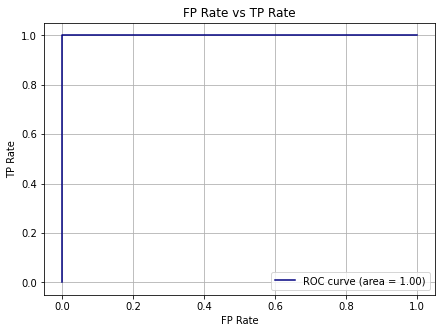

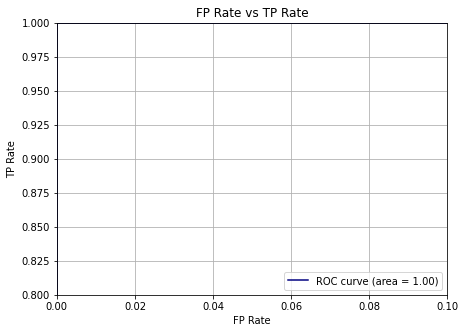

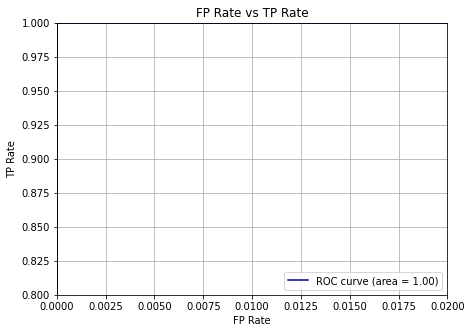

In [21]:
plt.figure(1,figsize=(7,5)) 
plt.plot(fpr, tpr,
         label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='navy')
plt.legend(loc="lower right")
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('FP Rate vs TP Rate') 
plt.grid(True)
plt.savefig(import_directory+'FPRTPR.png', dpi=300)

plt.figure(2,figsize=(7,5))
plt.xlim(0, 0.1)
plt.ylim(0.8, 1)
plt.plot(fpr, tpr,
         label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='navy')
plt.legend(loc="lower right")
plt.xlabel('FP Rate') 
plt.ylabel('TP Rate') 
plt.title('FP Rate vs TP Rate') 
plt.grid(True)
plt.savefig(import_directory+'FPRTPRzoom.png', dpi=300)

plt.figure(3,figsize=(7,5))
plt.xlim(0, 0.02)
plt.ylim(0.8, 1)
plt.plot(fpr, tpr,
         label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='navy')
plt.legend(loc="lower right")
plt.xlabel('FP Rate') 
plt.ylabel('TP Rate') 
plt.title('FP Rate vs TP Rate') 
plt.grid(True)
plt.savefig(import_directory+'FPRTPRzoom2x.png', dpi=300)

In [ ]:
result = f1_score(testY,rounded, average='macro')
print("F1 macro = ",result)

F1 macro =  0.9921800274696662


In [ ]:
result = f1_score(testY,rounded, average='micro')
print("F1 Micro= ",result)

F1 Micro=  0.9926598158281063


In [ ]:
result = f1_score(testY,rounded, average='weighted')
print("F1 Weighted= ",result)

F1 Weighted=  0.9926727411610384


In [ ]:
#fpr1, tpr1, _ = roc_curve(testY, predictions)
#roc_auc1 = auc(fpr1, tpr1)
#fpr2, tpr2, _ = roc_curve(testY, predictions)
#roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3, _ = roc_curve(testY, predictions)
roc_auc3 = auc(fpr3, tpr3)
#print("fpr : ", fpr)
#print("tpr : ", tpr)
#print(threshold)

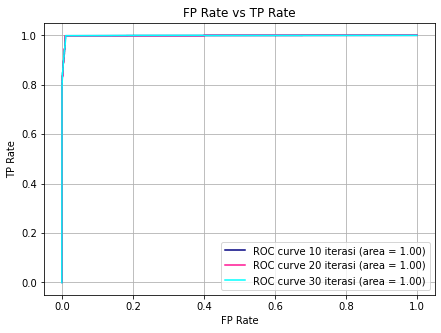

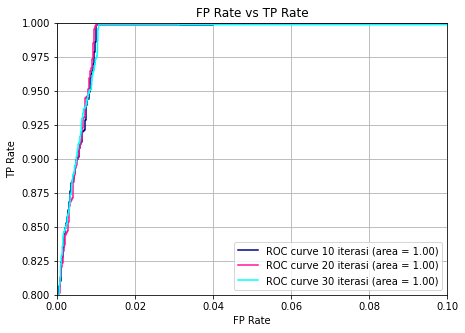

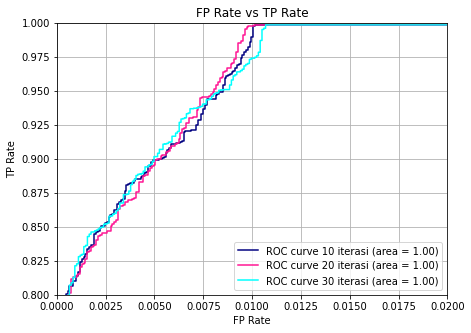

In [ ]:
plt.figure(1,figsize=(7,5)) 
plt.plot(fpr1, tpr1,
         label='ROC curve 10 iterasi (area = {0:0.2f})'
               ''.format(roc_auc),
         color='navy')
plt.plot(fpr2, tpr2,
         label='ROC curve 20 iterasi (area = {0:0.2f})'
               ''.format(roc_auc2),
         color='deeppink')
plt.plot(fpr3, tpr3,
         label='ROC curve 30 iterasi (area = {0:0.2f})'
               ''.format(roc_auc3),
         color='aqua')
plt.legend(loc="lower right")
plt.xlabel('FP Rate') 
plt.ylabel('TP Rate') 
plt.title('FP Rate vs TP Rate') 
plt.grid(True)
plt.savefig(import_directory+'FPRTPRorig.png', dpi=300)
plt.figure(2,figsize=(7,5))
plt.xlim(0, 0.1)
plt.ylim(0.8, 1)
plt.plot(fpr1, tpr1,
         label='ROC curve 10 iterasi (area = {0:0.2f})'
               ''.format(roc_auc),
         color='navy')
plt.plot(fpr2, tpr2,
         label='ROC curve 20 iterasi (area = {0:0.2f})'
               ''.format(roc_auc2),
         color='deeppink')
plt.plot(fpr3, tpr3,
         label='ROC curve 30 iterasi (area = {0:0.2f})'
               ''.format(roc_auc3),
         color='aqua')
plt.legend(loc="lower right")
plt.xlabel('FP Rate') 
plt.ylabel('TP Rate') 
plt.title('FP Rate vs TP Rate') 
plt.grid(True)
plt.savefig(import_directory+'FPRTPRzoom.png', dpi=300)
plt.figure(3,figsize=(7,5))
plt.xlim(0, 0.02)
plt.ylim(0.8, 1)
plt.plot(fpr1, tpr1,
         label='ROC curve 10 iterasi (area = {0:0.2f})'
               ''.format(roc_auc),
         color='navy')
plt.plot(fpr2, tpr2,
         label='ROC curve 20 iterasi (area = {0:0.2f})'
               ''.format(roc_auc2),
         color='deeppink')
plt.plot(fpr3, tpr3,
         label='ROC curve 30 iterasi (area = {0:0.2f})'
               ''.format(roc_auc3),
         color='aqua')
plt.legend(loc="lower right")
plt.xlabel('FP Rate') 
plt.ylabel('TP Rate') 
plt.title('FP Rate vs TP Rate') 
plt.grid(True)
plt.savefig(import_directory+'FPRTPRzoom2x.png', dpi=300)

In [ ]:
#save_model = "/content/drive/My Drive/TeA/project/datasets/datasets-test-V7a/"

data_dir = os.path.dirname(import_directory)
data_file = os.path.basename(data_dir)
new_file = import_directory+data_file
my_model.save(new_file+"-5epochs-hd5.hd5")
my_model.save(new_file+"-5epochs-h5.h5")

In [ ]:
v_index= 4
x_valid = trainX[:5]
a = get_activations(my_model, x_valid[v_index:v_index+1], auto_compile=True)
display_activations(a)

Output hidden; open in https://colab.research.google.com to view.